# **Relação entre gastos militares das nações e seu impacto econômico: positivo ou negativo?**

---


# 1) Importando e tratando os dados

In [1]:
from google.colab import files

uploaded = files.upload()

Saving dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv to dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0 (1).csv
Saving SIPRI-Milex-data-2014-2024.xlsx to SIPRI-Milex-data-2014-2024 (1).xlsx


In [15]:
!pip install --upgrade scipy

In [2]:
# para lidar com os dados
import pandas as pd

# importando as bases de dados de seus respctivos caminhos
sipri_data = pd.read_excel(
    'SIPRI-Milex-data-2014-2024.xlsx',
    sheet_name=[
        'Constant (2023) US$', 'Current US$', 'Share of GDP',
        'Per capita', 'Share of Govt. spending'
    ]
)
fmi_data = pd.read_csv('dataset_2025-06-04T01_01_07.768164706Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv')


# a) Tratando a base **sipri_data**

In [3]:
# passando os dados para o formato long com .melt(), de modo que um ano esteja associado a mais de uma variável
constant_exp_long = sipri_data['Constant (2023) US$'].melt(id_vars=['Country'], var_name='Year', value_name='militar_expenses')
current_exp_long = sipri_data['Current US$'].melt(id_vars=['Country'], var_name='Year', value_name='militar_expenses_cur')
gdp_share_long = sipri_data['Share of GDP'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_share_of_gdp')
percap_exp_long = sipri_data['Per capita'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_per_capita')
govspend_long = sipri_data['Share of Govt. spending'].melt(id_vars=['Country'], var_name='Year', value_name='expenses_share_of_gov')

# definindo e aplicando a função clean para converter valores não numéricos e eliminá-los se nulos
def clean(df, value_col):
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    df['Year'] = df['Year'].astype(int)
    return df

constant_exp_long = clean(constant_exp_long, 'militar_expenses')
current_exp_long = clean(current_exp_long, 'militar_expenses_cur')
gdp_share_long = clean(gdp_share_long, 'expenses_share_of_gdp')
percap_exp_long = clean(percap_exp_long, 'expenses_per_capita')
govspend_long = clean(govspend_long, 'expenses_share_of_gov')

# mergindo cada uma delas sucessivamente até termos um único dataframe
military_expenses = constant_exp_long.merge(current_exp_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(gdp_share_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(percap_exp_long, on=['Country', 'Year'], how='outer')
military_expenses = military_expenses.merge(govspend_long, on=['Country', 'Year'], how='outer')

# remover linhas nulas e verificando se funcionou com .sum()
military_expenses = military_expenses.dropna(subset=[
    'militar_expenses', 'militar_expenses_cur',
    'expenses_share_of_gdp', 'expenses_per_capita',
    'expenses_share_of_gov'
])

print(military_expenses.isna().sum())

# verificando nosso df final
print(military_expenses.info())
print(military_expenses.head())

Country                  0
Year                     0
militar_expenses         0
militar_expenses_cur     0
expenses_share_of_gdp    0
expenses_per_capita      0
expenses_share_of_gov    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1621 entries, 0 to 1759
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                1621 non-null   object 
 1   Year                   1621 non-null   int64  
 2   militar_expenses       1621 non-null   float64
 3   militar_expenses_cur   1621 non-null   float64
 4   expenses_share_of_gdp  1621 non-null   float64
 5   expenses_per_capita    1621 non-null   float64
 6   expenses_share_of_gov  1621 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 101.3+ KB
None
       Country  Year  militar_expenses  militar_expenses_cur  \
0  Afghanistan  2014        245.148024            268.238788   
1  Afghanistan  2015        196.

# b) Tratando a base **fmi_data**

In [4]:
# removendo colunas desnecessárias do df e renomeando a coluna 'COUNTRY' para o merge
fmi_data = fmi_data.drop(columns=['DATASET','SERIES_CODE', 'OBS_MEASURE', 'FREQUENCY', 'SCALE'])
fmi_data = fmi_data.rename(columns={'COUNTRY':'Country'})

# passando os dados para o formato long com .melt(), de modo que um ano esteja associado a mais de uma variável
col_years = ['2014', '2015', '2016', '2017', '2018', '2019','2020','2021','2022','2023','2024']
fmi_data_melt = fmi_data.melt(
    id_vars=['Country', 'INDICATOR'],
    value_vars=col_years,
    var_name='Year',
    value_name='Value'
)
# criando uma coluna para cada indicador com a função .pivot()
fmi_data_pivot_melt = fmi_data_melt.pivot(
    index=['Country', 'Year'],
    columns='INDICATOR',
    values= 'Value'
)




print(fmi_data_pivot_melt.head())

INDICATOR     External debt, Percent of GDP  External debt, US dollar  \
Country Year                                                            
ASEAN-5 2014                            NaN                       NaN   
        2015                            NaN                       NaN   
        2016                            NaN                       NaN   
        2017                            NaN                       NaN   
        2018                            NaN                       NaN   

INDICATOR     Gross debt, General government, Percent of GDP  \
Country Year                                                   
ASEAN-5 2014                                          45.097   
        2015                                          46.503   
        2016                                          46.584   
        2017                                          47.129   
        2018                                          48.377   

INDICATOR     Gross domestic product (G

# c) **Merge** dos DFs

In [5]:
# mergindo os dois dfs

tabelona = pd.merge(military_expenses, fmi_data_pivot_melt, on='Country', how='outer')

print(tabelona.info())
print(tabelona.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14224 entries, 0 to 14223
Data columns (total 15 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Country                                                              14224 non-null  object 
 1   Year                                                                 13091 non-null  float64
 2   militar_expenses                                                     13091 non-null  float64
 3   militar_expenses_cur                                                 13091 non-null  float64
 4   expenses_share_of_gdp                                                13091 non-null  float64
 5   expenses_per_capita                                                  13091 non-null  float64
 6   expenses_share_of_gov                                                13091 non-null  float64
 7   Exte

# 2) Gráficos e valores

In [6]:
# para termos uma ideia das estatísticas das variáveis
print(tabelona.describe())

               Year  militar_expenses  militar_expenses_cur  \
count  13091.000000      13091.000000          13091.000000   
mean    2018.985639       7542.061222           7161.658504   
std        3.153463      29551.928346          26839.473345   
min     2014.000000          7.879396              5.296050   
25%     2016.000000        266.401885            229.639906   
50%     2019.000000       1156.068342           1000.922131   
75%     2022.000000       5604.794361           5336.875740   
max     2024.000000     968381.594851         997309.000000   

       expenses_share_of_gdp  expenses_per_capita  expenses_share_of_gov  \
count           13091.000000         13091.000000           13091.000000   
mean                0.018268           268.294016               0.061613   
std                 0.020676           456.467264               0.050294   
min                 0.000356             0.514279               0.000028   
25%                 0.009436            22.588715   

In [7]:
# para criar gráficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# removendo coluna com nomes para criação do gráfico
tabelona=tabelona.drop(columns=['Country'])

# heatmap para avaliarmos as relações de maneira holística
plt.figure(figsize=(14, 10))
sns.heatmap(tabelona.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('📊 Matriz de Correlação entre Gastos Militares e Indicadores Econômicos')
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'ASEAN-5'

<Figure size 1400x1000 with 0 Axes>

**Iremos focar nossa análise em correlações que sejam numericamente superiores a 0,30 pelo menos**

# **Relações**

# i. Gastos militares e **PIB**

-0.09202191452997183
3.8752110652077325e-25


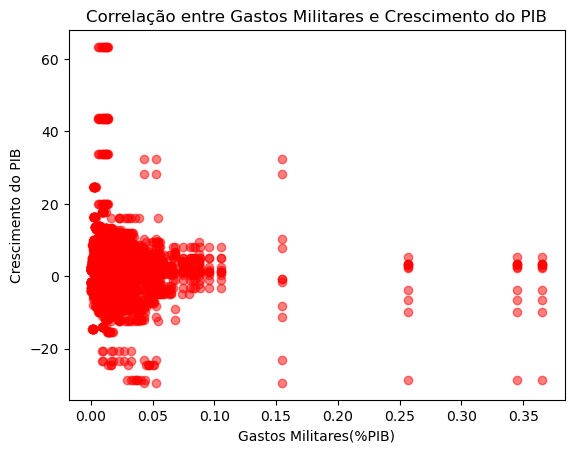

In [ ]:
# examinando a relação entre gastos militares e crescimento do PIB com o coeficiente de pearson


x = tabelona_gastos_crescimentoPIB ['expenses_share_of_gdp']
y = tabelona_gastos_crescimentoPIB ["Gross domestic product (GDP), Constant prices, Percent change"]

corr_coef, p_value = pearsonr(x, y)

print(corr_coef)
print(p_value)
plt.scatter(tabelona_gastos_crescimentoPIB["expenses_share_of_gdp"],tabelona_gastos_crescimentoPIB["Gross domestic product (GDP), Constant prices, Percent change"], color='red', alpha=0.5)
plt.xlabel("Gastos Militares(%PIB)")
plt.ylabel("Crescimento do PIB")
plt.title("Correlação entre Gastos Militares e Crescimento do PIB")
plt.show()

In [ ]:
fig = px.scatter(
    tabelona,
    x="Gross domestic product (GDP), Current prices, Per capita, US dollar",
    y="expenses_per_capita",
    labels={
        "Gross domestic product (GDP), Current prices, Per capita, US dollar": "PIB per capita (US$)",
        "expenses_per_capita": "Despesa Militar per capita (US$)"
    },
    title="Relação entre PIB per capita e Despesa Militar per capita",
    opacity=0.6
)

fig.show()

# ii. Gastos militares e **dívida**

0.02911750709945381
0.0010879957166885456


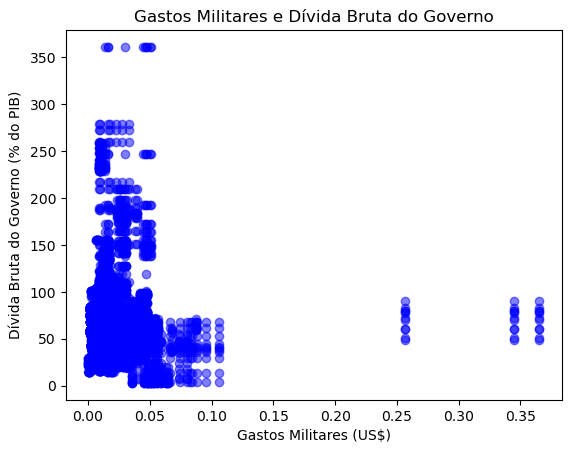

In [ ]:
# examinando a correlação entre gastos militares e dívida do governo
import numpy as np
from scipy.stats import pearsonr
x=tabelona_gastos_divida['expenses_share_of_gdp']
y= tabelona_gastos_divida ['Gross debt, General government, Percent of GDP']

corr_coef, p_value= pearsonr(x,y)
print(corr_coef)
print(p_value)

# scatter da relação
plt.scatter(tabelona_gastos_divida ['expenses_share_of_gdp'], tabelona_gastos_divida ['Gross debt, General government, Percent of GDP'], color='blue', alpha=0.5)
plt.xlabel('Gastos Militares (US$)')
plt.ylabel('Dívida Bruta do Governo (% do PIB)')
plt.title('Gastos Militares e Dívida Bruta do Governo')
plt.show()

# iii. Gastos militares e **população**

0.5360718917284961
0.0


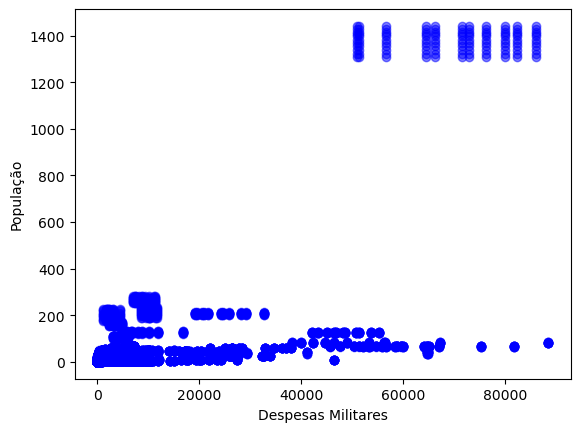

In [ ]:
from scipy.stats import pearsonr
x=tabelona_gastos_pop["militar_expenses_cur"]
y=tabelona_gastos_pop["Population, Persons for countries / Index for country groups"]
corr_coef, p_value= pearsonr(x,y)
print(corr_coef)
print(p_value)

tabelona_gastos_pop= tabelona[["militar_expenses_cur", "Population, Persons for countries / Index for country groups"]].dropna()
plt.scatter(tabelona_gastos_pop["militar_expenses_cur"],tabelona_gastos_pop["Population, Persons for countries / Index for country groups"], color="blue", alpha=0.5)
plt.xlabel("Despesas Militares")
plt.ylabel("População")
plt.show()

# iv. Gastos militares e **desemprego**

-0.12141852349124133
4.085262935198695e-27


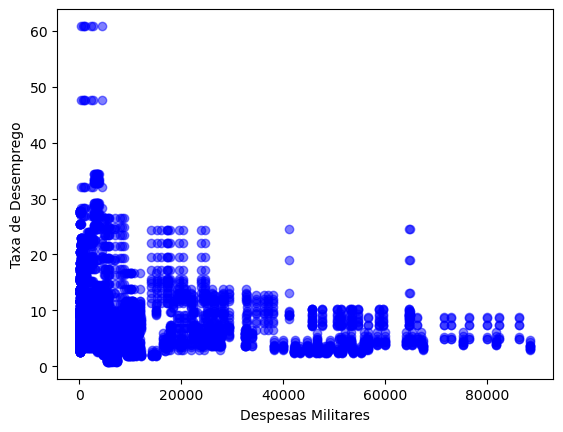

In [ ]:
import numpy as np
from scipy.stats import pearsonr
x=tabelona_gastos_desemprego["militar_expenses_cur"]
y=tabelona_gastos_desemprego["Unemployment rate"]
corr_coef, p_value= pearsonr(x,y)
print(corr_coef)
print(p_value)

tabelona_gastos_desemprego= tabelona[["militar_expenses_cur", "Unemployment rate"]].dropna()
plt.scatter(tabelona_gastos_desemprego["militar_expenses_cur"],tabelona_gastos_desemprego["Unemployment rate"], color="blue", alpha=0.5)
plt.xlabel("Despesas Militares")
plt.ylabel("Taxa de Desemprego")
plt.show()

# Caso: Brasil

In [ ]:
df_brasil = tabelona[tabelona["Country"] == "Brazil"].copy()
df_brasil["Year"] = df_brasil["Year"].astype(int)

fig = px.line(
    df_brasil,
    x="Year",
    y="expenses_per_capita",
    markers=True,
    title="Despesa Militar per capita no Brasil (US$)"
)
fig.update_layout(xaxis_title="Ano", yaxis_title="US$ por pessoa")
fig.show()